<a href="https://colab.research.google.com/github/qetibakh/ML-Homework1/blob/main/fer2013_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [11]:
!pip install wandb torch torchvision matplotlib seaborn scikit-learn kaggle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
import wandb

print("Setup complete!")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

# Wandb login

In [12]:
wandb.login()
print("WandB ready!")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: qetibaxtura (qetibaxtura-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


WandB ready!


# Download Data

In [13]:
from google.colab import files
print("Upload your kaggle.json file:")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!unzip -q challenges-in-representation-learning-facial-expression-recognition-challenge.zip

print("Dataset ready!")

Upload your kaggle.json file:


Saving kaggle.json to kaggle.json
 90% 258M/285M [00:00<00:00, 496MB/s]
100% 285M/285M [00:00<00:00, 495MB/s]
Dataset ready!


# Dataset class

In [14]:
class FER2013Dataset(Dataset):
    def __init__(self, csv_file, usage='Training', transform=None):
        self.data = pd.read_csv(csv_file)
        self.data = self.data[self.data[' Usage'] == usage].reset_index(drop=True)  # Added space!
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert pixels to image
        pixels = self.data.iloc[idx][' pixels']  # Added space here too!
        image = np.array([int(p) for p in pixels.split()], dtype=np.uint8).reshape(48, 48)
        image = Image.fromarray(image, mode='L')

        if self.transform:
            image = self.transform(image)

        emotion = int(self.data.iloc[idx]['emotion'])  # No space for emotion
        return image, emotion

# Model architectures

In [15]:
class SimpleConvNet(nn.Module):
    """Experiment 1:"""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)      # 48->44
        self.pool1 = nn.MaxPool2d(2, 2)      # 44->22
        self.conv2 = nn.Conv2d(6, 16, 5)     # 22->18
        self.pool2 = nn.MaxPool2d(2, 2)      # 18->9
        self.fc1 = nn.Linear(16 * 9 * 9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class SmallFilterCNN(nn.Module):
    """Experiment 2: 3x3 filters"""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)   # 48->48
        self.pool1 = nn.MaxPool2d(2, 2)               # 48->24
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # 24->24
        self.pool2 = nn.MaxPool2d(2, 2)               # 24->12
        self.fc1 = nn.Linear(64 * 12 * 12, 512)
        self.fc2 = nn.Linear(512, 7)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class RegularizedCNN(nn.Module):
    """Experiment 3: Add dropout"""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 7)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

class BatchNormCNN(nn.Module):
    """Experiment 4: Add BatchNorm)"""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 7)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)


# Training functions

In [16]:
def train_model(model_class, experiment_name, epochs=20, use_augmentation=False):
    """Train a model and log to WandB"""

    # Initialize WandB
    wandb.init(project="fer2013-cs231n", name=experiment_name, reinit=True)

    # Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_class().to(device)

    # Data transforms
    if use_augmentation:
        train_transform = transforms.Compose([
            transforms.RandomRotation(10),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    # Datasets
    train_dataset = FER2013Dataset('icml_face_data.csv', 'Training', train_transform)
    val_dataset = FER2013Dataset('icml_face_data.csv', 'PublicTest', val_transform)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Count parameters
    params = sum(p.numel() for p in model.parameters())
    print(f"{experiment_name}: {params:,} parameters")

    best_val_acc = 0

    # Training loop
    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validate
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(target.cpu().numpy())

        # Calculate accuracies
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        # Log to WandB
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss / len(train_loader),
            'train_acc': train_acc,
            'val_loss': val_loss / len(val_loader),
            'val_acc': val_acc
        })

        if val_acc > best_val_acc:
            best_val_acc = val_acc

        print(f"Epoch {epoch+1}: Train {train_acc:.1f}%, Val {val_acc:.1f}%")

    # Final confusion matrix
    emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    cm = confusion_matrix(all_targets, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotions, yticklabels=emotions)
    plt.title(f'{experiment_name} - Confusion Matrix')
    plt.show()

    print(f"Best validation accuracy: {best_val_acc:.2f}%")
    wandb.finish()
    return best_val_acc


# Run experiments

## Expetiment 1: Simple CNN Baseline

Experiment 1: Simple CNN


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


exp1_simple_cnn: 168,971 parameters
Epoch 1: Train 35.0%, Val 41.4%
Epoch 2: Train 43.8%, Val 46.5%
Epoch 3: Train 48.7%, Val 48.5%
Epoch 4: Train 52.1%, Val 51.4%
Epoch 5: Train 55.1%, Val 52.3%
Epoch 6: Train 57.8%, Val 53.1%
Epoch 7: Train 60.7%, Val 53.4%
Epoch 8: Train 63.3%, Val 53.6%
Epoch 9: Train 66.2%, Val 53.7%
Epoch 10: Train 68.7%, Val 52.4%
Epoch 11: Train 71.3%, Val 53.2%
Epoch 12: Train 73.4%, Val 52.5%
Epoch 13: Train 76.0%, Val 53.3%
Epoch 14: Train 78.3%, Val 52.6%
Epoch 15: Train 80.8%, Val 51.3%


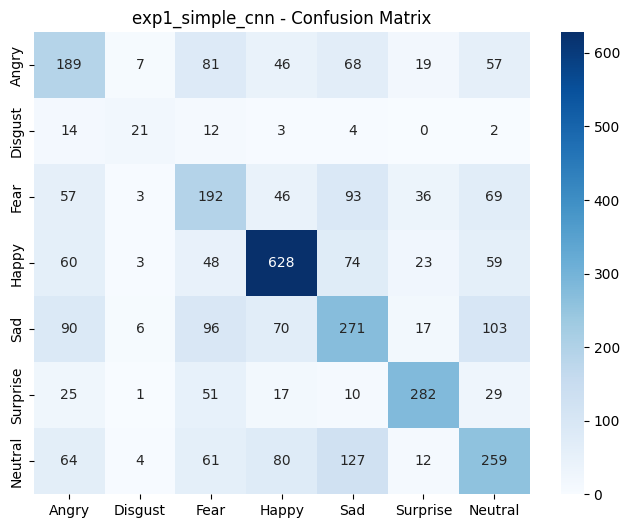

Best validation accuracy: 53.66%


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▂▃▄▄▄▅▅▆▆▇▇▇██
train_loss,█▇▆▆▅▅▄▄▃▃▃▂▂▁▁
val_acc,▁▄▅▇▇████▇█▇█▇▇
val_loss,▅▃▂▁▁▁▁▂▂▃▄▅▆██
epoch,15
train_acc,80.79696
train_loss,0.53438
val_acc,51.32349
val_loss,1.75408


In [17]:
print("Experiment 1: Simple CNN")
result1 = train_model(SimpleConvNet, "exp1_simple_cnn", epochs=15)

## Experiment 2: Smaller Filters

In [ ]:
print("Experiment 2: Small Filters (3x3)")
result2 = train_model(SmallFilterCNN, "exp2_small_filters", epochs=15)

## Experiment 3: Add Regularization

In [ ]:
print("Experiment 3: Add Dropout + Data Augmentation")
result3 = train_model(RegularizedCNN, "exp3_regularized", epochs=20, use_augmentation=True)

## Experiment 4: Batch Normalization

In [ ]:
print("Experiment 4: Add Batch Normalization")
result4 = train_model(BatchNormCNN, "exp4_batch_norm", epochs=20, use_augmentation=True)

# Results summary

In [ ]:
results = {
    'Simple CNN': result1,
    'Small Filters': result2,
    'Regularized': result3,
    'Batch Norm': result4
}

plt.figure(figsize=(10, 6))
bars = plt.bar(results.keys(), results.values())
plt.title('Experiment Results Comparison')
plt.ylabel('Best Validation Accuracy (%)')
plt.xticks(rotation=45)

# Color bars
colors = ['red', 'orange', 'blue', 'green']
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.tight_layout()
plt.show()

print("Final Results:")
for exp, acc in results.items():
    print(f"{exp}: {acc:.2f}%")